In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_text as text          # needed for loading bert from hub
from official.nlp import optimization   # to create AdamW optimizer
from matplotlib import pyplot as plt
from collections import defaultdict

tf.get_logger().setLevel('ERROR')
tf.__version__, tf.config.list_physical_devices('GPU')

('2.10.1', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [2]:
from utils.preprocessing import preprocess

raw_ds = preprocess('tfcm')

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0


In [3]:
valueRange = set(raw_ds['score'].values())
len(raw_ds['score']), len(valueRange)

(24160, 52)

In [4]:
countLine = 0
countID = defaultdict(int)
flag = False
countInLine = 0
flagIn = False
for line in raw_ds['test']:
    for ID in line:
        if ID not in raw_ds['score']:
            countID[ID] += 1
            flag = True
        else:
            flagIn = True
    if flag:
        countLine += 1
        flag = False
    if flagIn:
        countInLine += 1
        flagIn = False
countLine, countInLine, len(raw_ds['test']), len(countID)

(2460, 2590, 3000, 6179)

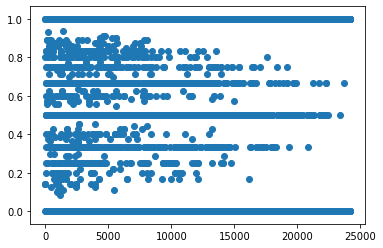

In [5]:
plt.scatter(range(len(raw_ds['score'])), raw_ds['score'].values())
plt.show()

In [6]:
np.array(raw_ds['train_reg'])[:,0]

array(['4800559', '170616', '5116575', ..., '43364', '101553', '3462228'],
      dtype='<U32')

In [7]:
train_data = np.vectorize(id2text:= lambda x: raw_ds['news'][x])(np.array(raw_ds['train_reg'])[:,0])
train_label = np.array(raw_ds['train_reg'])[:,1].astype(np.float32)
valid_data = np.vectorize(id2text)(np.array(raw_ds['valid_reg'])[:,0])
valid_label = np.array(raw_ds['valid_reg'])[:,1].astype(np.float32)
valid_label

array([0.6666667, 0.       , 1.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(21744, 2416)

In [9]:
# tf.compat.v1.disable_eager_execution()
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train, num_valid = len(train_ds), len(valid_ds)
num_train, num_valid

(680, 76)

In [10]:
for x, y in train_ds.take(1):
    print(x[0].shape, x[1].shape, y.shape)
y

(32,) (32,) (32,)


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [11]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.metrics.MeanAbsoluteError()
epochs = 1
num_train_steps = num_train * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
title_units = 16
content_units = 64
fine_tune = True

In [12]:
from model import tfcm

if tf.__version__.startswith('2.10'):
    os.environ['TFHUB_CACHE_DIR'] = 'model/hub_cache'
regressioner = tfcm.build_regression_model(title_units, content_units, fine_tune=fine_tune)

In [13]:
from utils.visualization import plot_structure, plot_history

plot_structure(regressioner, 'bert_regressioner.png')

In [14]:
regressioner.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = regressioner.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])

680/680 [==============================] - 671s 971ms/step - loss: 0.2153 - mean_absolute_error: 0.4311 - val_loss: 0.2145 - val_mean_absolute_error: 0.4334


In [15]:
test_data = np.vectorize(id2text)(np.array(list(raw_ds['test_reg'])))
test_label = regressioner.predict(test_data)
test_label

194/194 [==============================] - 166s 847ms/step


array([[0.71879494],
       [0.7400173 ],
       [0.5799408 ],
       ...,
       [0.70364547],
       [0.7099278 ],
       [0.618264  ]], dtype=float32)

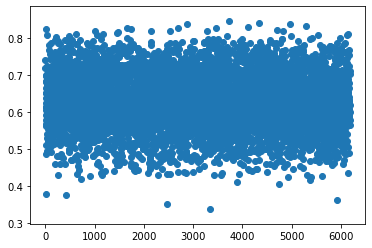

In [16]:
plt.scatter(range(len(test_label)), test_label)
plt.show()

In [17]:
scores = dict(raw_ds['score'], **dict(zip(raw_ds['test_reg'], test_label.flatten())))
scores

{'44374': 0.0,
 '44416': 0.14285714285714285,
 '2913537': 0.14285714285714285,
 '2913541': 0.14285714285714285,
 '3074529': 1.0,
 '49422': 1.0,
 '49429': 0.8,
 '7785735': 1.0,
 '132569': 1.0,
 '132604': 1.0,
 '132610': 1.0,
 '46844': 1.0,
 '2990192': 0.5,
 '2991404': 1.0,
 '2991427': 1.0,
 '2991450': 1.0,
 '2992028': 0.6666666666666666,
 '2993613': 0.6,
 '2957871': 1.0,
 '2958394': 1.0,
 '45884': 1.0,
 '2959890': 1.0,
 '46062': 1.0,
 '165623': 1.0,
 '165624': 1.0,
 '165671': 1.0,
 '8744403': 1.0,
 '165686': 1.0,
 '165699': 1.0,
 '165772': 1.0,
 '2745143': 1.0,
 '37582': 1.0,
 '2745231': 1.0,
 '2745306': 0.5,
 '151530': 0.4,
 '151551': 0.0,
 '151624': 0.0,
 '31314': 1.0,
 '31333': 1.0,
 '31341': 1.0,
 '31358': 1.0,
 '31368': 1.0,
 '140549': 1.0,
 '140567': 1.0,
 '140563': 1.0,
 '140624': 1.0,
 '3411064': 0.0,
 '59866': 0.0,
 '59921': 0.5,
 '3414600': 0.0,
 '84699': 0.0,
 '4871183': 0.0,
 '84702': 0.0,
 '5353284': 0.8333333333333334,
 '94600': 1.0,
 '5355512': 0.75,
 '3531193': 1.0,
 '64

In [18]:
test_data = [[scores[ID] for ID in line] for line in raw_ds['test']]
test_data

[[1.0, 1.0, 0.6666666666666666, 0.6666666666666666],
 [1.0, 1.0, 0.5, 0.59082246, 1.0],
 [0.5089353, 0.6148853, 0.5285233],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [0.6967079, 1.0, 1.0],
 [1.0, 0.6174322, 0.875],
 [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.7142857142857143, 1.0],
 [0.0, 0.0, 0.4],
 [1.0, 1.0, 1.0, 1.0],
 [0.72181964, 0.9375, 0.8823529411764706],
 [0.62468535,
  0.5190406,
  0.46945328,
  0.6007609,
  0.6609401,
  0.8333333333333334,
  0.8],
 [0.63972723, 0.6910089, 1.0],
 [0.51636916, 0.6050251, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 0.6020754, 1.0, 1.0, 1.0],
 [0.6621317, 0.5595445, 0.6370152],
 [0.6247435, 0.5875187, 0.5194438],
 [0.0, 0.61782044, 0.66445106, 0.6279324, 0.6792367, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [0.6442661, 0.72928005, 0.7275735, 0.0, 0.5],
 [0.6786186, 0.6029137, 1.0],
 [0.6871051, 0.60714495, 1.0, 1.0, 1.0, 0.69113904],
 [1.0, 0.56983066, 1.0, 1.0],
 [1.0, 0.7027176, 1.0, 0.5742545, 1.0],
 [0.4865527, 0.59781134, 0.5, 0.0, 0.5],
 [0.6, 

In [19]:
train_data, train_label = raw_ds['train_cls']
valid_data, valid_label = raw_ds['valid_cls']
maxlen = max(max(len(i) for i in test_data), max(len(i) for i in train_data), max(len(i) for i in valid_data))
maxlen

64

In [20]:
pad_value = 0.45
test_ds = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', value=pad_value, dtype='float32')
test_ds

array([[1.        , 1.        , 0.6666667 , ..., 0.45      , 0.45      ,
        0.45      ],
       [1.        , 1.        , 0.5       , ..., 0.45      , 0.45      ,
        0.45      ],
       [0.5089353 , 0.6148853 , 0.5285233 , ..., 0.45      , 0.45      ,
        0.45      ],
       ...,
       [0.53921497, 1.        , 0.6554461 , ..., 0.45      , 0.45      ,
        0.45      ],
       [0.51279217, 0.558532  , 1.        , ..., 0.45      , 0.45      ,
        0.45      ],
       [0.6300792 , 0.60796195, 0.6590851 , ..., 0.45      , 0.45      ,
        0.45      ]], dtype=float32)

In [21]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', value=pad_value, dtype='float32')
valid_data = tf.keras.preprocessing.sequence.pad_sequences(valid_data, maxlen=maxlen, padding='post', value=pad_value, dtype='float32')
train_data.shape, train_label.shape, valid_data.shape, valid_label.shape

((7158, 64), (7158,), (796, 64), (796,))

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_label))
len(train_ds), len(valid_ds)

(7158, 796)

In [23]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
num_train, num_valid = len(train_ds), len(valid_ds)
num_train, num_valid

(224, 25)

In [24]:
list(train_ds.as_numpy_iterator())[0][0].shape, list(train_ds.as_numpy_iterator())[0][1].shape

((32, 64), (32,))

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [tf.metrics.BinaryAccuracy(),
              tf.metrics.Precision(),
              tf.metrics.Recall(),
              tf.metrics.AUC()]
epochs = 5
init_lr = 1e-4
optimizer = tf.keras.optimizers.Nadam(learning_rate=init_lr)
config = [
    {'units': 64, 'activation': 'elu', 'regularizer': ('l2', 1e-2), 'batch_norm': True, 'dropout': 0},
    {'units': 16, 'activation': 'softplus', 'regularizer': ('l1', 1e-3), 'batch_norm': False, 'dropout': 0}
]
classifier = tfcm.build_classifier_model(maxlen, config)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,473
Trainable params: 5,345
Non-trainable params: 128
_________________________________________________________________
None


Epoch 1/5
224/224 [==============================] - 5s 16ms/step - loss: 0.9629 - binary_accuracy: 0.9458 - precision: 0.9739 - recall: 0.9396 - auc: 0.9901 - val_loss: 0.9788 - val_binary_accuracy: 0.9724 - val_precision: 0.9602 - val_recall: 0.9980 - val_auc: 0.9993
Epoch 2/5
224/224 [==============================] - 3s 15ms/step - loss: 0.6815 - binary_accuracy: 0.9763 - precision: 0.9888 - recall: 0.9735 - auc: 0.9975 - val_loss: 0.6278 - val_binary_accuracy: 0.9899 - val_precision: 0.9960 - val_recall: 0.9882 - val_auc: 0.9994
Epoch 3/5
224/224 [==============================] - 3s 14ms/step - loss: 0.5386 - binary_accuracy: 0.9774 - precision: 0.9886 - recall: 0.9755 - auc: 0.9980 - val_loss: 0.4708 - val_binary_accuracy: 0.9925 - val_precision: 0.9980 - val_recall: 0.9901 - val_auc: 0.9994
Epoch 4/5
224/224 [==============================] - 3s 15ms/step - loss: 0.4399 - binary_accuracy: 0.9779 - precision: 0.9884 - recall: 0.9766 - auc: 0.9981 - val_loss: 0.3845 - val_binary_

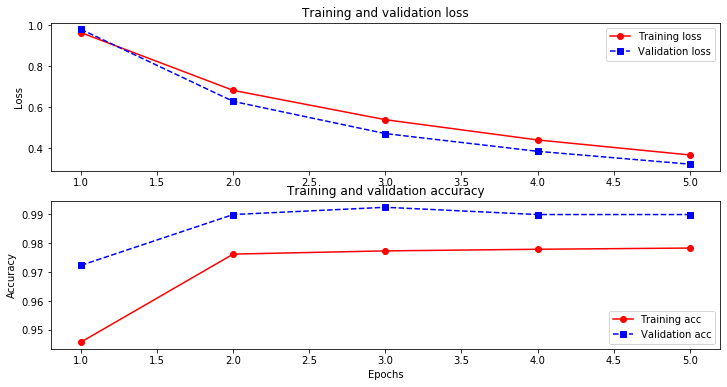

In [26]:
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = classifier.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[callbacks])
plot_history(history.history)

In [27]:
from utils.prediction import predict

test_ds_label = predict(classifier, test_ds, 'tfcm_prediction.txt')

94/94 [==============================] - 0s 2ms/step
